In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
!pip install yfinance --upgrade --no-cache-dir

In [3]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
%cd "/content/drive/MyDrive/RP"

Mounted at /content/drive
/content/drive/MyDrive/RP


In [4]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
df = pdr.get_data_yahoo("LT.NS", start="2022-01-03").reset_index()
df.to_csv('/content/LT.csv',index=False)
df.head()

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-03,1895.000000,1937.449951,1893.650024,1922.849976,1894.265625,1906676
1,2022-01-04,1922.849976,1943.000000,1914.550049,1937.550049,1908.747070,1643920
2,2022-01-05,1940.699951,1951.000000,1927.650024,1948.599976,1919.632812,1711667
3,2022-01-06,1944.500000,1953.000000,1919.599976,1924.500000,1895.891113,1372015
4,2022-01-07,1929.050049,1934.949951,1897.150024,1904.900024,1876.582520,1447123


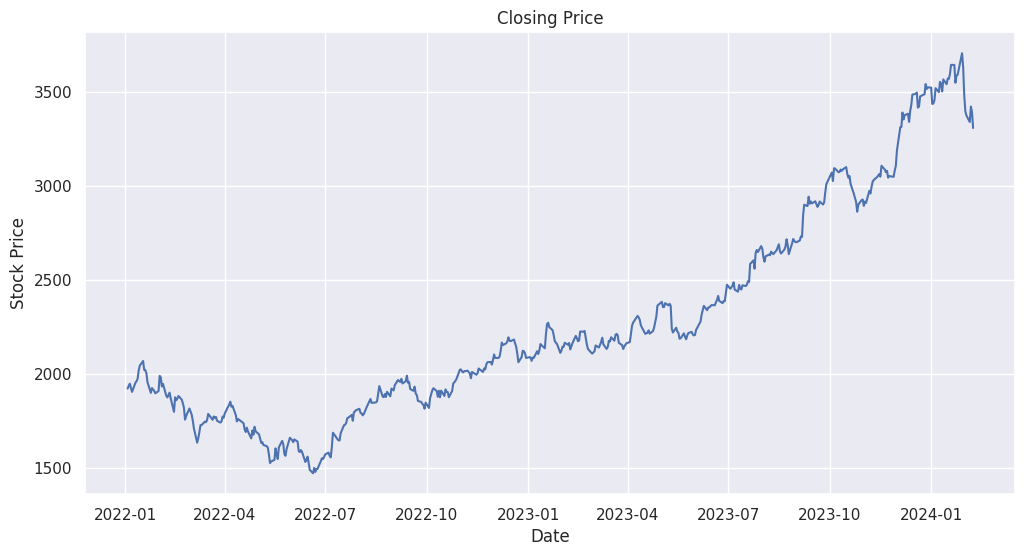

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'])
plt.title('Closing Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

In [6]:
df = pd.read_csv('/content/LT.csv')

### Policy Gradient agent

In [29]:
import tensorflow as tf
name = 'Policy Gradient agent'
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r

    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)

    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)

            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))


            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )

            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest


    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]

                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [8]:
!pip install --upgrade tensorflow

In [30]:
close = df.Close.values.tolist()
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 400, checkpoint = 20, initial_money = initial_money)

<ipython-input-29-a37d34a986d8>:19: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
<ipython-input-29-a37d34a986d8>:20: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
<ipython-input-29-a37d34a986d8>:109: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-

epoch: 20, total rewards: 3604.900879.3, cost: -2999.836426, total money: 13604.900879
epoch: 40, total rewards: 1816.250122.3, cost: -3909.024414, total money: 11816.250122
epoch: 60, total rewards: 1765.300537.3, cost: -3986.535889, total money: 11765.300537
epoch: 80, total rewards: 3709.150024.3, cost: -4304.452148, total money: 13709.150024
epoch: 100, total rewards: 2786.150391.3, cost: -3914.523193, total money: 12786.150391
epoch: 120, total rewards: 3436.999756.3, cost: -4513.115723, total money: 13436.999756
epoch: 140, total rewards: 2487.349854.3, cost: -4299.974121, total money: 12487.349854
epoch: 160, total rewards: 4819.699585.3, cost: -3467.389648, total money: 14819.699585
epoch: 180, total rewards: 2750.149536.3, cost: -5130.480957, total money: 12750.149536
epoch: 200, total rewards: 4080.000732.3, cost: -5058.365723, total money: 14080.000732
epoch: 220, total rewards: 2505.800781.3, cost: -4621.776367, total money: 12505.800781
epoch: 240, total rewards: 1738.6002

In [31]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 1: buy 1 unit at price 1937.550049, total balance 8062.449951
day 2: buy 1 unit at price 1948.599976, total balance 6113.849976
day 3, sell 1 unit at price 1924.500000, investment -0.673534 %, total balance 8038.349976,
day 4, sell 1 unit at price 1904.900024, investment -2.242633 %, total balance 9943.250000,
day 5: buy 1 unit at price 1953.099976, total balance 7990.150024
day 6: buy 1 unit at price 1961.150024, total balance 6029.000000
day 7, sell 1 unit at price 1974.199951, investment 1.080333 %, total balance 8003.199951,
day 8: buy 1 unit at price 2018.400024, total balance 5984.799927
day 9: buy 1 unit at price 2044.750000, total balance 3940.049927
day 10: buy 1 unit at price 2069.399902, total balance 1870.650024
day 11, sell 1 unit at price 2022.199951, investment 3.112966 %, total balance 3892.849976,
day 12: buy 1 unit at price 2020.900024, total balance 1871.949951
day 14, sell 1 unit at price 1956.050049, investment -3.089079 %, total balance 3828.000000,
day 15, se

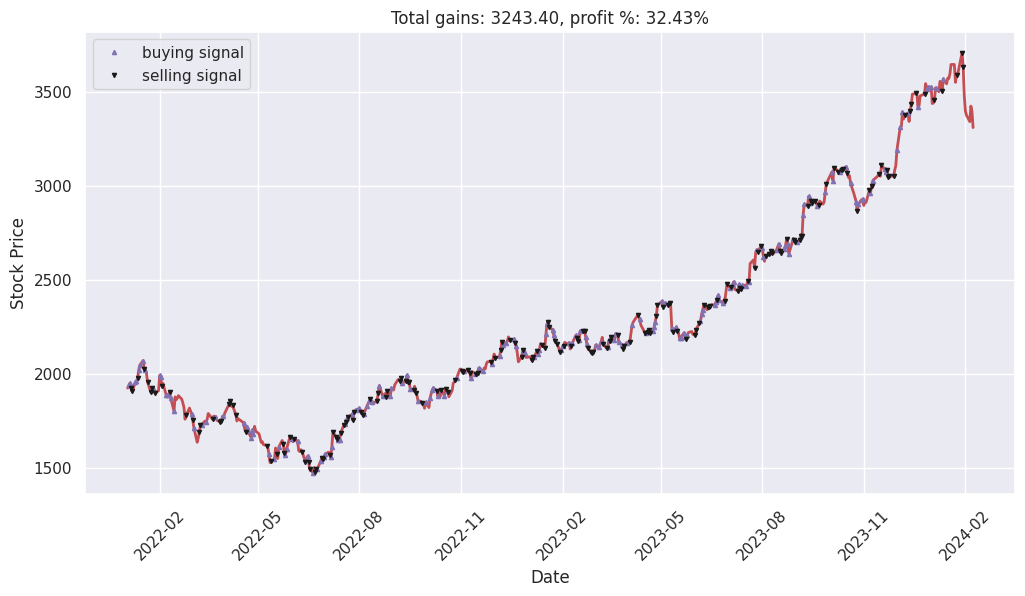

In [34]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/LT.csv')

# Extract date and close price
date = pd.to_datetime(df['Date'])
close = df['Close']

# Get the index of the first closing value
first_closing_index = close.first_valid_index()

# Extract the date and close price starting from the first closing value
date = date[first_closing_index:]
close = close[first_closing_index:]
plt.figure(figsize=(12, 6))
plt.plot(date, close, color='r', lw=2.)

# Plot markers for buying and selling signals
plt.plot(date[states_buy], close[states_buy], '^', markersize=3, color='m', label='buying signal')
plt.plot(date[states_sell], close[states_sell], 'v', markersize=3, color='k', label='selling signal')

plt.title('Total gains: %.2f, profit %%: %.2f%%' % (total_gains, invest))

# Set the locator for x-axis ticks to show dates every three months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()
